In [1]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
import jax
import os

import jaxley as jx
import jaxley.optimize.transforms as jt
from jaxley.channels import Na, K, Leak, CaL, CaT, HH
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import connect

import optax
import time as time

import pandas as pd

In [3]:
n_post_comp = 15
num_pre = 8
post_idx = num_pre # post cell index inside the network
Nsyn = num_pre

i_delay = 10.0    # ms
i_amp = 0.2   # nA
i_dur = 10.0   # ms
dt = 0.025  # ms
t_max = 50.0   # ms

base_amp = i_amp

syn_post_comp_indices = np.linspace(0, n_post_comp - 1, num_pre).astype(int)

def build_net():
    comp_pre = jx.Compartment()
    branch_pre = jx.Branch(comp_pre, ncomp=1)
    cell_pre = jx.Cell(branch_pre, parents=np.asarray([-1]))

    comp_post = jx.Compartment()
    branch_post = jx.Branch(comp_post, ncomp=n_post_comp)
    cell_post = jx.Cell(branch_post, parents=np.asarray([-1]))

    pre_cells = [cell_pre for _ in range(num_pre)]
    cells = pre_cells + [cell_post]
    net = jx.Network(cells)

    net.insert(HH())

    syn = IonotropicSynapse()
    for pre_i, comp_i in zip(range(num_pre), syn_post_comp_indices):
        connect(
            net.cell(pre_i).branch(0).comp(0),
            net.cell(post_idx).branch(0).comp(int(comp_i)),
            syn,
        )
    return net

def setup_recordings(net_obj):
    net_obj.delete_recordings()
    net_obj.cell(post_idx).branch(0).comp(0).record()  # syn 0 = soma
    for ci in syn_post_comp_indices:
        if int(ci) != 0:
            net_obj.cell(post_idx).branch(0).comp(int(ci)).record()
    return net_obj

net_analysis = build_net()


# net_analysis.edges.loc[:, "IonotropicSynapse_s"] = 0.05

net_analysis = setup_recordings(net_analysis)

net_analysis.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")
params_true = net_analysis.get_parameters()
print(f"Network: {net_analysis.nodes.shape[0]} compartments, "
      f"{net_analysis.edges.shape[0]} edges")
print(f"Number of synapses = {Nsyn}, syn_post_comp_indices = {syn_post_comp_indices}")




Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 8. Total number of trainable parameters: 8
Network: 23 compartments, 8 edges
Number of synapses = 8, syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]


In [4]:
print("node columns:", list(net_analysis.nodes.columns))

cols = [c for c in net_analysis.nodes.columns]

print("showing cols:", cols)
display(net_analysis.nodes[cols].head(15))

node columns: ['local_cell_index', 'local_branch_index', 'local_comp_index', 'length', 'radius', 'axial_resistivity', 'capacitance', 'v', 'area', 'volume', 'resistive_load_in', 'resistive_load_out', 'x', 'y', 'z', 'global_cell_index', 'global_branch_index', 'global_comp_index', 'controlled_by_param', 'HH', 'HH_gNa', 'HH_gK', 'HH_gLeak', 'HH_eNa', 'HH_eK', 'HH_eLeak', 'HH_m', 'HH_h', 'HH_n']
showing cols: ['local_cell_index', 'local_branch_index', 'local_comp_index', 'length', 'radius', 'axial_resistivity', 'capacitance', 'v', 'area', 'volume', 'resistive_load_in', 'resistive_load_out', 'x', 'y', 'z', 'global_cell_index', 'global_branch_index', 'global_comp_index', 'controlled_by_param', 'HH', 'HH_gNa', 'HH_gK', 'HH_gLeak', 'HH_eNa', 'HH_eK', 'HH_eLeak', 'HH_m', 'HH_h', 'HH_n']


,local_cell_index,local_branch_index,local_comp_index,length,radius,axial_resistivity,capacitance,v,area,volume,...,HH,HH_gNa,HH_gK,HH_gLeak,HH_eNa,HH_eK,HH_eLeak,HH_m,HH_h,HH_n
0,0,0,0,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,...,True,0.12,0.036,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2
1,1,0,0,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,...,True,0.12,0.036,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2
2,2,0,0,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,...,True,0.12,0.036,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2
3,3,0,0,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,...,True,0.12,0.036,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2
4,4,0,0,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,...,True,0.12,0.036,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2
5,5,0,0,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,...,True,0.12,0.036,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2
6,6,0,0,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,...,True,0.12,0.036,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2
7,7,0,0,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,...,True,0.12,0.036,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2
8,8,0,0,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,...,True,0.12,0.036,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2
9,8,0,1,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,...,True,0.12,0.036,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2


In [5]:
t_warm = 40    
i_delay_eff = t_warm + i_delay #start
t_max_eff = t_warm + t_max #end
T_keep = int(round(t_max/dt)) + 1
i0 = int(round(t_warm/dt))
print(f"Warmup: t_warm={t_warm} ms, i0={i0}, T_keep={T_keep}, "
      f"total sim = {t_max_eff} ms")

def simulate_analysis(params_phys, pattern):
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay_eff, i_dur=i_dur,
        i_amp=amps, delta_t=dt, t_max=t_max_eff,
    )
    net_analysis.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_analysis.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(net_analysis, params=params_phys,
                          data_stimuli=data_stimuli, delta_t=dt)

    # crop out warmup toreturn clean 0...50ms window
    return traces[:, i0:i0 + T_keep]

def simulate_soma(params_phys, pattern):
    return simulate_analysis(params_phys, pattern)[0]   # (T,)

batched_simulate_soma = vmap(simulate_soma, in_axes=(None, 0)) # get many traces at once 

def loss_and_traces(params_phys, pattern, target):
    raw_traces = simulate_analysis(params_phys, pattern)
    soma_pred = raw_traces[0]
    loss = jnp.mean((soma_pred - target) ** 2)
    return loss, raw_traces

_vg_fn = jit(value_and_grad(loss_and_traces, argnums=0, has_aux=True))

def single_trial(params_phys, pattern, target):
    (loss, raw_traces), grads = _vg_fn(params_phys, pattern, target)
    grad_w = grads[0]["IonotropicSynapse_gS"]       # (Nsyn,)
    return grad_w, raw_traces, loss

# batched over patterns (shared params)
batched_vg = jit(jax.vmap(
    jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True),
    in_axes=(None, 0, 0),
))



Warmup: t_warm=40 ms, i0=1600, T_keep=2001, total sim = 90.0 ms


In [6]:
print(f"Params_true = {params_true}")

Params_true = [{'IonotropicSynapse_gS': Array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],      dtype=float64)}]


In [7]:
gS_true = params_true[0]["IonotropicSynapse_gS"]
params_true = [{"IonotropicSynapse_gS": gS_true}]
transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])

opt_params_true = transform.inverse(params_true)
key_learn = jax.random.PRNGKey(1)
sigma = 0.05  # 5% lognormal perturbation
gS_learned = jnp.clip(
    gS_true * jnp.exp(sigma * jax.random.normal(key_learn, (Nsyn,))),
    1e-5, 1e-2
)
params_analysis = [{"IonotropicSynapse_gS": gS_learned}]
gS_learned = params_analysis[0]["IonotropicSynapse_gS"]

print("gS_true:", gS_true)
print("gS_learned:", gS_learned)
print(f"max |diff|: {float(jnp.max(jnp.abs(gS_true - gS_learned))):.2e}")



gS_true: [0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
gS_learned: [9.42504843e-05 9.94208316e-05 1.00867190e-04 1.04902940e-04
 9.59207643e-05 1.03514370e-04 1.00377964e-04 9.62495051e-05]
max |diff|: 5.75e-06


In [8]:
patterns_zero = jnp.zeros(Nsyn,dtype=jnp.float64) # (8, 8)
print(f"\npatterns zero shape: {patterns_zero.shape}")
print(patterns_zero)

targets_zero = batched_simulate_soma(params_true, patterns_zero[None, :]) 
T = targets_zero.shape[1]                                   
t_arr = np.arange(T_keep) * dt

print(f"\ntargets_zero shape: {targets_zero.shape}")
print(f"T = {T},  dt = {dt} ms,  t_max = {t_max} ms")



patterns zero shape: (8,)
[0. 0. 0. 0. 0. 0. 0. 0.]

targets_zero shape: (1, 2001)
T = 2001,  dt = 0.025 ms,  t_max = 50.0 ms


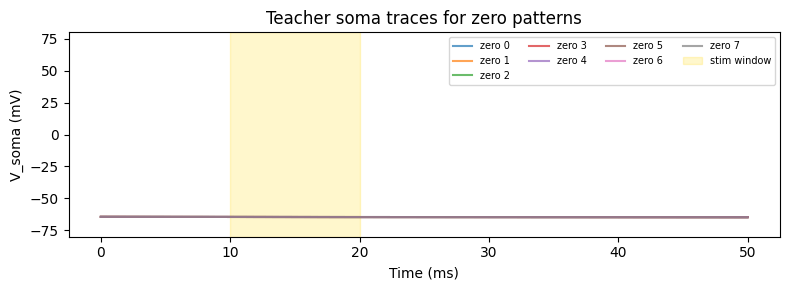

In [9]:
fig, ax = plt.subplots(figsize=(8, 3))
for p in range(Nsyn):
    ax.plot(t_arr, targets_zero[p], alpha=0.7, label=f"zero {p}")
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_ylim(-80, 80)
ax.set_xlabel("Time (ms)"); ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for zero patterns")
ax.legend(fontsize=7, ncol=4)
plt.tight_layout(); plt.show()

In [10]:
patterns_onehot = jnp.eye(Nsyn, dtype=jnp.float64)   # (8, 8)
print(f"\npatterns_onehot shape: {patterns_onehot.shape}")
print(patterns_onehot)

targets_onehot = batched_simulate_soma(params_true, patterns_onehot)   # (8, T)
T = targets_onehot.shape[1]                                            # time axis
t_arr = np.arange(T_keep) * dt

print(f"\ntargets_onehot shape: {targets_onehot.shape}")
print(f"T = {T},  dt = {dt} ms,  t_max = {t_max} ms")


patterns_onehot shape: (8, 8)
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

targets_onehot shape: (8, 2001)
T = 2001,  dt = 0.025 ms,  t_max = 50.0 ms


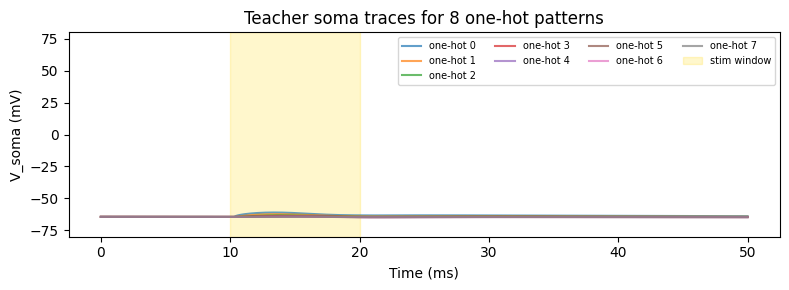

In [11]:
fig, ax = plt.subplots(figsize=(8, 3))
for p in range(Nsyn):
    ax.plot(t_arr, targets_onehot[p], alpha=0.7, label=f"one-hot {p}")
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_ylim(-80, 80)
ax.set_xlabel("Time (ms)"); ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for 8 one-hot patterns")
ax.legend(fontsize=7, ncol=4)
plt.tight_layout(); plt.show()

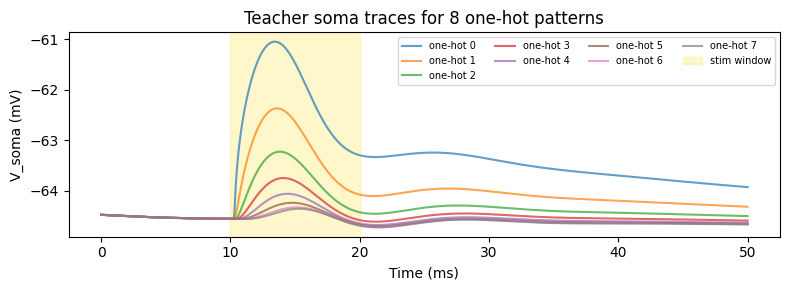

In [12]:
fig, ax = plt.subplots(figsize=(8, 3))
for p in range(Nsyn):
    ax.plot(t_arr, targets_onehot[p], alpha=0.7, label=f"one-hot {p}")
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_xlabel("Time (ms)"); ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for 8 one-hot patterns")
ax.legend(fontsize=7, ncol=4)
plt.tight_layout(); plt.show()

In [13]:
patterns_train = patterns_onehot # (8, 8) — identity matrix
targets_train = targets_onehot # (8, T) — teacher soma traces (see above!!)
N_train = patterns_train.shape[0]  # 8

print(f"Training set: {N_train} one-hot patterns × {Nsyn} synapses")
print(f"patterns_train shape: {patterns_train.shape}")
print(f"targets_train shape: {targets_train.shape}")
print(f"Target V range: [{float(targets_train.min()):.2f}, "
      f"{float(targets_train.max()):.2f}] mV")
print(f"\nPatterns (each row activates exactly 1 synapse):")
print(np.asarray(patterns_train))


Training set: 8 one-hot patterns × 8 synapses
patterns_train shape: (8, 8)
targets_train shape: (8, 2001)
Target V range: [-64.72, -61.05] mV

Patterns (each row activates exactly 1 synapse):
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [14]:
net_train = build_net()
# net_train.edges.loc[:, "IonotropicSynapse_s"] = 0.05   # near resting s_inf
net_train.delete_recordings()
net_train.cell(post_idx).branch(0).comp(0).record() # soma only
for ci in syn_post_comp_indices:
    if int(ci) != 0:
        net_train.cell(post_idx).branch(0).comp(int(ci)).record() # all synapses except soma
net_train.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")

train_transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])

def _sim_soma_train(params_phys, pattern):
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay_eff, i_dur=i_dur, i_amp=amps, delta_t=dt, t_max=t_max_eff,
    )
    net_train.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_train.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(
        net_train, params=params_phys,
        data_stimuli=data_stimuli, delta_t=dt,
    )
    # crop out warmup to return clean 0...50ms window
    return traces[0, i0:i0 + T_keep] # (T,)

_batched_soma_train = vmap(_sim_soma_train, in_axes=(None, 0))

def _train_loss_batch(opt_params, pats, tgts):
    params_phys = train_transform.forward(opt_params)
    preds = _batched_soma_train(params_phys, pats)            # (B, T)
    return jnp.mean((preds - tgts) ** 2)

train_lr = 0.05
train_optimizer = optax.adam(train_lr)

@jit
def _train_step(opt_params, opt_state, pats, tgts):
    loss, grads = jax.value_and_grad(_train_loss_batch)(
        opt_params, pats, tgts,
    )
    updates, new_state = train_optimizer.update(grads, opt_state, opt_params)
    new_params = optax.apply_updates(opt_params, updates)
    return new_params, new_state, loss

checkpoints = [10, 25, 50]
n_steps_train = max(checkpoints)  

def train_one_seed(seed, patterns_train, targets_train,
                   n_steps=50, checkpoints=(10, 25, 50), log_every=5):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    gS0 = jnp.clip(
        1e-4 * jnp.exp(0.15 * jax.random.normal(subkey, (Nsyn,))),
        1e-5, 1e-2,
    )
    params0 = [{"IonotropicSynapse_gS": gS0}]
    opt_params = train_transform.inverse(params0)
    opt_state = train_optimizer.init(opt_params)

    loss_log = []
    checkpoint_params = {}   
    ckpt_set = set(checkpoints)

    for step in range(1, n_steps + 1):
        opt_params, opt_state, loss = _train_step(
            opt_params, opt_state, patterns_train, targets_train,
        )

        if step % log_every == 0 or step == n_steps:
            loss_log.append((step, float(loss)))

        if step in ckpt_set:
            checkpoint_params[step] = train_transform.forward(opt_params)

    return checkpoint_params, {"losses": loss_log, "final_loss": float(loss)}


print(f"Sanity check: training seed=0 ({n_steps_train} steps, "
      f"checkpoints at {checkpoints})")
t0 = time.time()
ckpt0, log0 = train_one_seed(0, patterns_train, targets_train)
t1 = time.time()
print(f"Time: {t1-t0:.1f}s")
print(f"Init loss: {log0['losses'][0][1]:.4f}")
print(f"Final loss:{log0['final_loss']:.4f}")
for c in sorted(ckpt0):
    gS_c = np.asarray(ckpt0[c][0]["IonotropicSynapse_gS"])
    print(f"gS @ step {c:3d}: {gS_c}  "
          f"(max |diff| from true = {np.abs(gS_c - np.asarray(gS_true)).max():.2e})")


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 8. Total number of trainable parameters: 8
Sanity check: training seed=0 (50 steps, checkpoints at [10, 25, 50])
Time: 70.8s
Init loss: 0.0005
Final loss:0.0000
gS @ step  10: [1.07862843e-04 9.08604287e-05 9.84552337e-05 9.46230733e-05
 9.21524599e-05 9.08802064e-05 9.48958945e-05 9.09353456e-05]  (max |diff| from true = 9.14e-06)
gS @ step  25: [9.85719289e-05 1.05416793e-04 9.84748945e-05 9.80170125e-05
 9.74637505e-05 1.05718655e-04 1.00206411e-04 1.06786877e-04]  (max |diff| from true = 6.79e-06)
gS @ step  50: [1.00307758e-04 1.01733960

In [15]:
S = 30

# added checkpoints
gS_ckpt = {c: np.zeros((S, Nsyn))           for c in checkpoints}  # (S,8)
GRADS_ckpt = {c: np.zeros((S, Nsyn, Nsyn))    for c in checkpoints}  # (S,8,8)
VALL_ckpt = {c: np.zeros((S, Nsyn, Nsyn, T)) for c in checkpoints}  # (S,8,8,T)
LOSS_ckpt = {c: np.zeros((S, Nsyn))           for c in checkpoints}  # (S,8)
train_logs_all = []

print(f"Training {S} seeds × {n_steps_train} steps  "
      f"(full-batch on {N_train} one-hots, lr={train_lr})")
print(f"Checkpoints: {checkpoints}")
print(f"Per-checkpoint shapes:  GRADS (S,8,8)  VALL (S,8,8,{T})  LOSS (S,8)\n")

t_start = time.time()

for s in range(S):
    t_seed = time.time()

    # ── Train ────────────────────────────────────────────────────────
    ckpt_params_s, log_s = train_one_seed(
        seed=s, patterns_train=patterns_train,
        targets_train=targets_train,
    )
    train_logs_all.append(log_s)

    # ── Evaluate each checkpoint on 8 one-hot probes ─────────────────
    for c in checkpoints:
        params_c = ckpt_params_s[c]
        gS_ckpt[c][s] = np.asarray(params_c[0]["IonotropicSynapse_gS"])

        ((losses_c, traces_c), grads_c) = batched_vg(
            params_c, patterns_onehot, targets_onehot,
        )
        GRADS_ckpt[c][s] = np.asarray(grads_c[0]["IonotropicSynapse_gS"])  # (8,8)
        VALL_ckpt[c][s]  = np.asarray(traces_c)                            # (8,8,T)
        LOSS_ckpt[c][s]  = np.asarray(losses_c)                            # (8,)

    dt_seed = time.time() - t_seed
    if s % 5 == 0 or s == S - 1:
        losses_str = "  ".join(
            f"step{c}={log_s['final_loss'] if c == checkpoints[-1] else float(LOSS_ckpt[c][s].mean()):.4f}"
            for c in checkpoints
        )
        print(f"  seed {s:3d}/{S}  {losses_str}  ({dt_seed:.1f}s)")

elapsed = time.time() - t_start
print(f"\nDone: {S} seeds in {elapsed:.1f}s  ({elapsed / S:.1f}s per seed)")
print(f"Train final-loss range: "
      f"[{min(l['final_loss'] for l in train_logs_all):.4f}, "
      f"{max(l['final_loss'] for l in train_logs_all):.4f}]")

# ── Quick per-checkpoint summary ─────────────────────────────────────
print(f"\nPer-checkpoint probe loss (mean across seeds & patterns):")
for c in checkpoints:
    print(f"  step {c:3d}:  mean loss = {LOSS_ckpt[c].mean():.6f}  "
          f"  gS spread (std) = {gS_ckpt[c].std(axis=0).mean():.2e}")


Training 30 seeds × 50 steps  (full-batch on 8 one-hots, lr=0.05)
Checkpoints: [10, 25, 50]
Per-checkpoint shapes:  GRADS (S,8,8)  VALL (S,8,8,2001)  LOSS (S,8)

  seed   0/30  step10=0.0023  step25=0.0003  step50=0.0000  (74.3s)
  seed   5/30  step10=0.0006  step25=0.0001  step50=0.0000  (67.1s)
  seed  10/30  step10=0.0001  step25=0.0001  step50=0.0000  (67.1s)
  seed  15/30  step10=0.0021  step25=0.0003  step50=0.0000  (67.2s)
  seed  20/30  step10=0.0015  step25=0.0003  step50=0.0000  (67.1s)
  seed  25/30  step10=0.0003  step25=0.0000  step50=0.0000  (67.2s)
  seed  29/30  step10=0.0002  step25=0.0001  step50=0.0000  (67.2s)

Done: 30 seeds in 2020.9s  (67.4s per seed)
Train final-loss range: [0.0000, 0.0002]

Per-checkpoint probe loss (mean across seeds & patterns):
  step  10:  mean loss = 0.000767    gS spread (std) = 5.97e-06
  step  25:  mean loss = 0.000225    gS spread (std) = 3.45e-06
  step  50:  mean loss = 0.000015    gS spread (std) = 1.07e-06


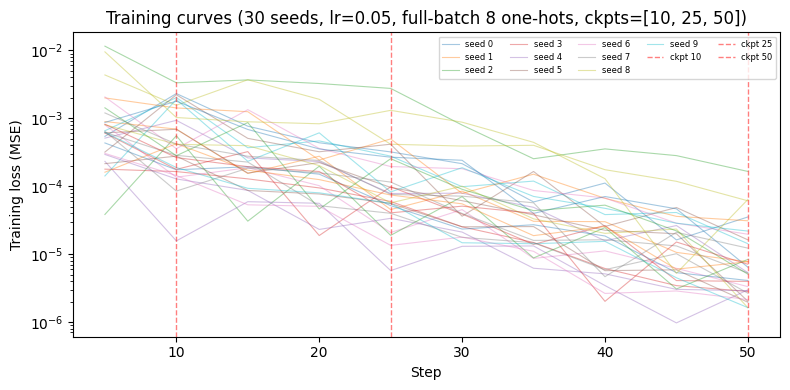

In [22]:
# training loss curves
fig, ax = plt.subplots(figsize=(8, 4))
for s_i, log_s in enumerate(train_logs_all):
    steps, losses = zip(*log_s["losses"])
    ax.plot(steps, losses, alpha=0.4, lw=0.8,
            label=f"seed {s_i}" if s_i < 10 else None)

for c in checkpoints:
    ax.axvline(c, color="red", ls="--", lw=1, alpha=0.5,
               label=f"ckpt {c}" if c == checkpoints[0] else f"ckpt {c}")
ax.set_xlabel("Step"); ax.set_ylabel("Training loss (MSE)")
ax.set_title(f"Training curves ({S} seeds, lr={train_lr}, "
             f"full-batch {N_train} one-hots, ckpts={checkpoints})")
ax.set_yscale("log")
ax.legend(fontsize=6, ncol=5)
plt.tight_layout(); plt.show()

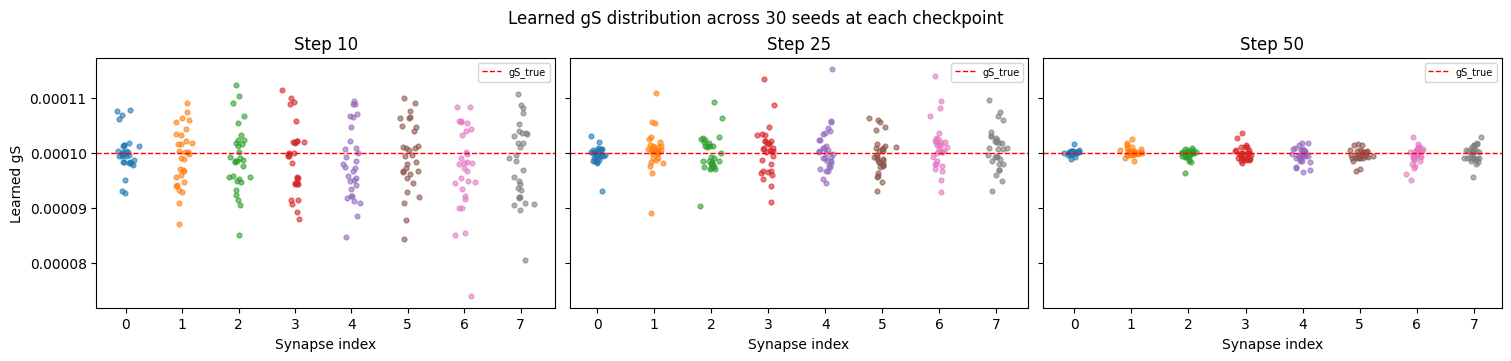

In [23]:
# learned gS at each checkpoint 
n_ckpt = len(checkpoints)
fig, axes = plt.subplots(1, n_ckpt, figsize=(5 * n_ckpt, 3.5),
                         sharey=True, constrained_layout=True)
for ci, c in enumerate(checkpoints):
    ax = axes[ci]
    for i in range(Nsyn):
        ax.scatter(np.full(S, i) + 0.08 * np.random.randn(S),
                   gS_ckpt[c][:, i], s=12, alpha=0.6)
    ax.axhline(float(gS_true[0]), color="red", ls="--", lw=1, label="gS_true")
    ax.set_xlabel("Synapse index")
    if ci == 0:
        ax.set_ylabel("Learned gS")
    ax.set_title(f"Step {c}")
    ax.legend(fontsize=7)
fig.suptitle(f"Learned gS distribution across {S} seeds at each checkpoint",
             fontsize=12)
plt.show()

In [24]:
# pearson correlation again
def corr_over_seeds(X, y, eps=1e-12):
    Xc = X - X.mean(axis=0, keepdims=True)
    yc = y - y.mean()
    num = (Xc * yc[:, None]).sum(axis=0)
    den = np.sqrt((Xc**2).sum(axis=0) * (yc**2).sum() + eps)
    return num / den

R_ckpt = {}   # {c: (8,8,8,T)}  -> R[p,i,j,t]
r_diag_ckpt = {}   # {c: (8,T)}  -> R[p,p,p,t]
r_off_ckpt = {}   # {c: (8,8,T)}  -> R[p,p,j,t] (includes diag too tho so just skip when not wanted!!!)

for c in checkpoints:
    Vraw = VALL_ckpt[c]  # (S,8,8,T)  
    G = GRADS_ckpt[c] # (S,8,8)

    R = np.zeros((Nsyn, Nsyn, Nsyn, T), dtype=np.float32)
    for p in range(Nsyn):
        for i in range(Nsyn):
            g_pi = G[:, p, i]  # (S,)
            for j in range(Nsyn):
                R[p, i, j, :] = corr_over_seeds(Vraw[:, p, j, :], g_pi).astype(np.float32)

    R_ckpt[c] = R
    r_diag_ckpt[c] = R[np.arange(Nsyn), np.arange(Nsyn), np.arange(Nsyn), :]  # (8,T)
    r_off_ckpt[c]  = R[np.arange(Nsyn), np.arange(Nsyn), :, :] # (8,8,T)

okay this may be really wrong but if i plot the diagonals then we are asking soemthing like: at time t, across different trained networks (seeds), do the networks that have a larger gradient for synapse p (when only synapse p is stimulated) also show higher voltage at synapse site p?

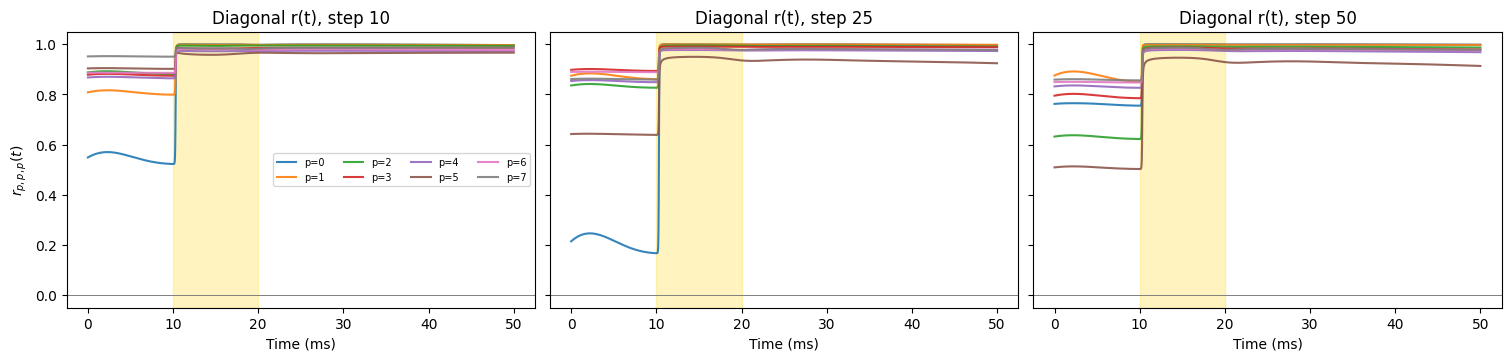

In [25]:
# diagonal r(t)
fig, axes = plt.subplots(1, n_ckpt, figsize=(5*n_ckpt, 3.5),
                         sharex=True, sharey=True, constrained_layout=True)

for ci, c in enumerate(checkpoints):
    ax = axes[ci]
    ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
    for p in range(Nsyn):
        ax.plot(t_arr, r_diag_ckpt[c][p], lw=1.5, alpha=0.9, label=f"p={p}")
    ax.axhline(0, color="grey", lw=0.7)
    ax.set_title(f"Diagonal r(t), step {c}")
    ax.set_xlabel("Time (ms)")
    if ci == 0:
        ax.set_ylabel(r"$r_{p,p,p}(t)$")
        ax.legend(fontsize=7, ncol=4)

plt.show()

When only synapse p is stimulated, and we look at the gradient for synapse p (i = p), which voltage recording site j (local synapse site vs other sites) best tracks that gradient across seeds, and when in time does it do so?

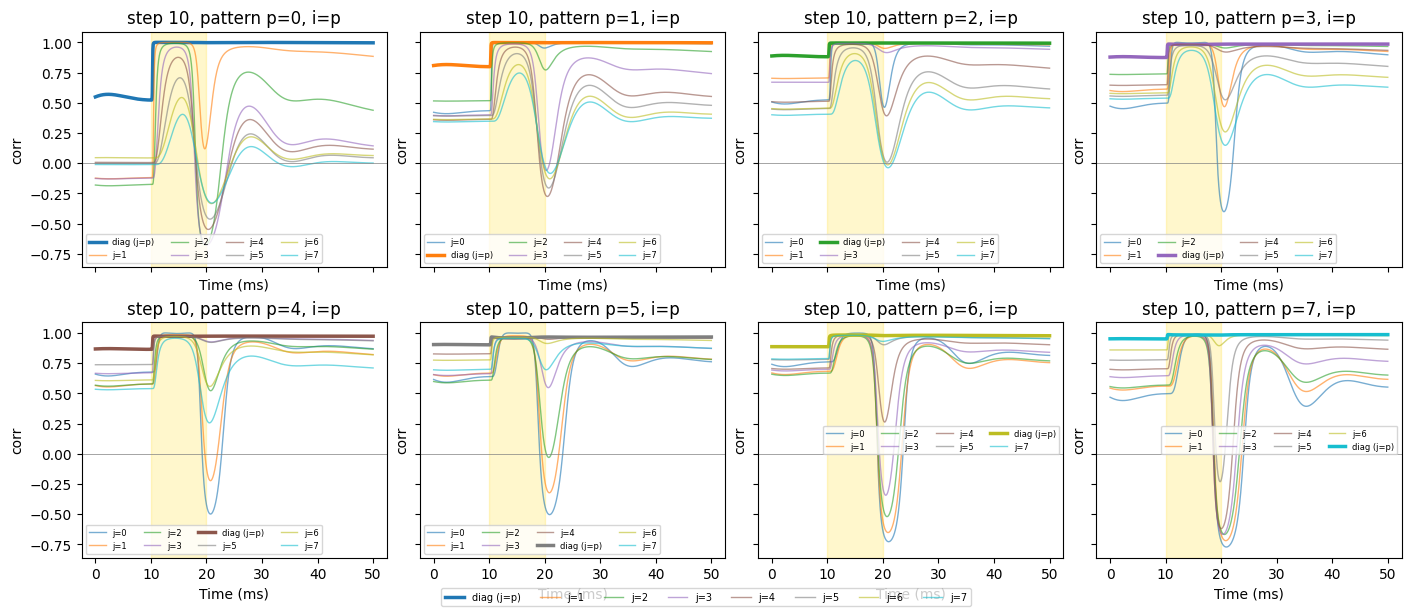

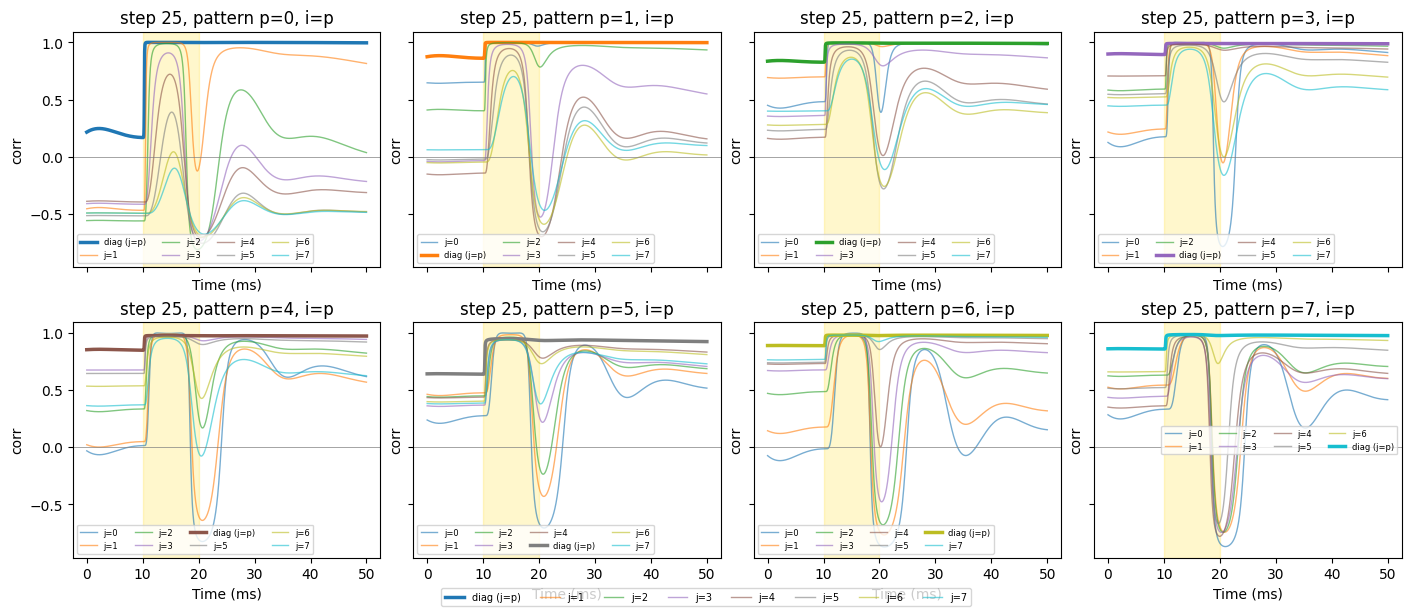

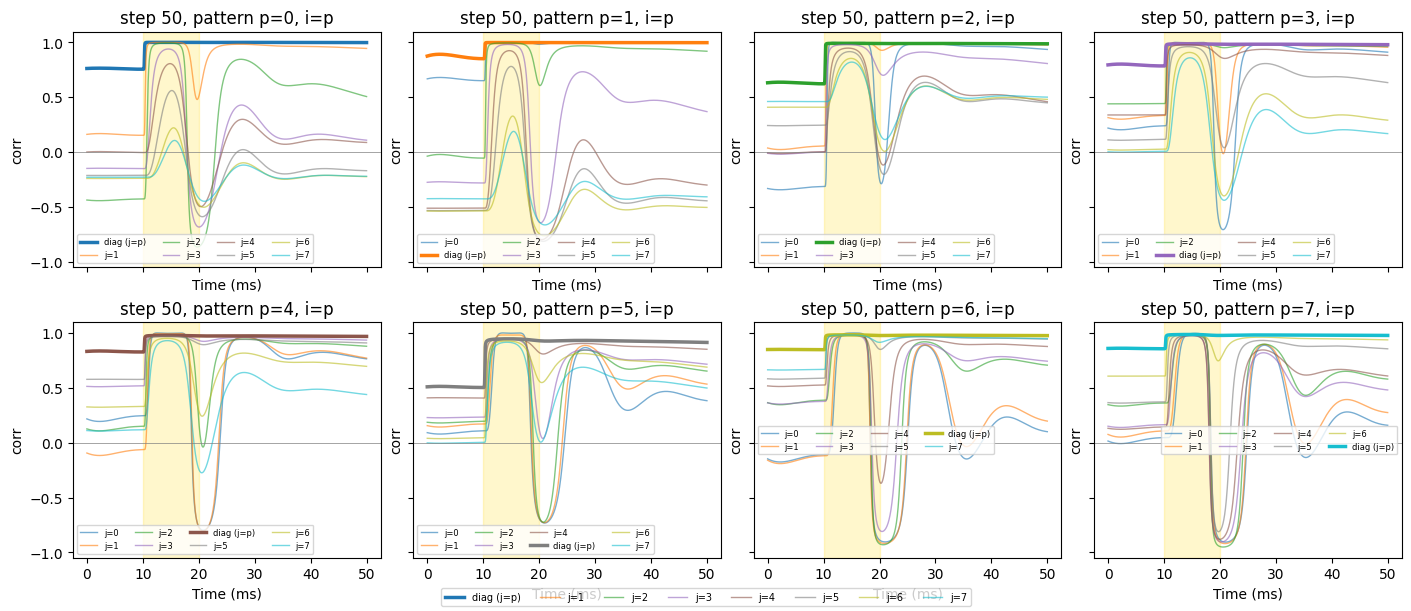

In [26]:
colors = plt.cm.tab10(np.linspace(0, 1, Nsyn))  # 8 distinct colors

for c in checkpoints:
    fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True,
                             constrained_layout=True)
    axes = axes.ravel()

    for p in range(Nsyn):
        ax = axes[p]
        ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2)

        # plot all sites j with fixed colors
        for j in range(Nsyn):
            lw = 2.5 if j == p else 1.0
            alpha = 1.0 if j == p else 0.6
            label = "diag (j=p)" if j == p else f"j={j}"
            ax.plot(t_arr, r_off_ckpt[c][p, j],
                    color=colors[j], lw=lw, alpha=alpha, label=label)

        ax.axhline(0, color="grey", lw=0.5)
        ax.set_title(f"step {c}, pattern p={p}, i=p")
        ax.set_xlabel("Time (ms)")
        ax.set_ylabel("corr")

        # optional: per-panel legend (small but correct)
        ax.legend(fontsize=6, ncol=4)

    # better: one global legend for the whole figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=9, fontsize=7)
    plt.show()
